# FLEXÃO NORMAL SIMPLES - DIFERENTES DIAGRAMAS PARA O CONCRETO


Este arquivo apresenta uma tentativa de implementar em código Python os exemplos apresentados no capítulo 1 do livro Curso de Concreto Armado - Tópicos Avançados, de José Milton Araújo.

O livro pode ser adquirido no seguinte link: https://www.editoradunas.com.br/volume7.html



## 1.1 INTRODUÇÃO

Diversos documentos normativos admitem diferentes modelos para representar o diagrama tensão–deformação do concreto no dimensionamento estrutural. Publicações como o Eurocode 2 e o fib Model Code 2010 permitem o uso dos três diagramas clássicos: parábola–retângulo, bilinear e retangular. De forma semelhante, o ACI também admite esses três modelos, apresentando apenas pequenas variações na formulação do diagrama parábola–retângulo.

No Brasil, a NBR 6118:2023 permite a utilização tanto do diagrama parábola–retângulo quanto do diagrama retangular equivalente.

Diante da possibilidade de uso de múltiplas curvas tensão-deformação, o objetivo deste código é comparar os resultados obtidos pelos diagramas parábola–retângulo, bilinear e retangular — avaliando suas semelhanças, diferenças e impacto no dimensionamento estrutural.

In [17]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

## 1.2 Diagramas tensão-deformação para o concreto
### a) Diagrama parábola-retângulo

Nas verificações de seções transversais à flexão simples ou composta, a NBR 6118/2014 adota o diagrama parábola-retângulo.

<figure style="text-align: center;">
    <img src="ParabolaRetangulo.png" width="480">
    <figcaption><strong>Figura 1 –</strong> Diagrama tensão–deformação parábola–retângulo.</figcaption>
</figure>


O diagrama tensão-deformação é descrito pelas seguintes expressões:

$$
\sigma_c(\varepsilon_c)=
\begin{cases}
0.85\,f_{cd}\left[1-\left(1-\dfrac{\varepsilon_c}{\varepsilon_o}\right)^{n}\right], 
&\varepsilon_c \le \varepsilon_o\\[10pt]
0.85\,f_{cd}, 
& \varepsilon_o < \varepsilon_c \le \varepsilon_u
\end{cases}
$$

Os valores a serem adotados para o parâmetro $\varepsilon_{c2}$, deformação específica de encurtamento do concreto no início do patamar plástico, são:

$$
\varepsilon_{c2}\,(\text{‰})=
\begin{cases}
2.0, 
& f_{ck} \le 50\ \text{MPa} \\[6pt]
2.0 + 0.085\,(f_{ck}-50)^{0.53}, 
& f_{ck} > 50\ \text{MPa}
\end{cases}
$$

Para os valores de $\varepsilon_{u}$, deformação específica de encurtamento do concreto na ruptura, adota-se:

$$
\varepsilon_{u}\,(\text{‰})=
\begin{cases}
3.5, 
& f_{ck} \le 50\ \text{MPa} \\[6pt]
2.6 + 35\left(\dfrac{90 - f_{ck}}{100}\right)^{4},
& f_{ck} > 50\ \text{MPa}
\end{cases}
$$

Por fim, para os valores do expoente \( n \), utiliza-se:

$$
n =
\begin{cases}
2.0,
& f_{ck} \le 50\ \text{MPa} \\[6pt]
1.4 + 23.4\left(\dfrac{90 - f_{ck}}{100}\right)^{4},
& f_{ck} > 50\ \text{MPa}
\end{cases}
$$

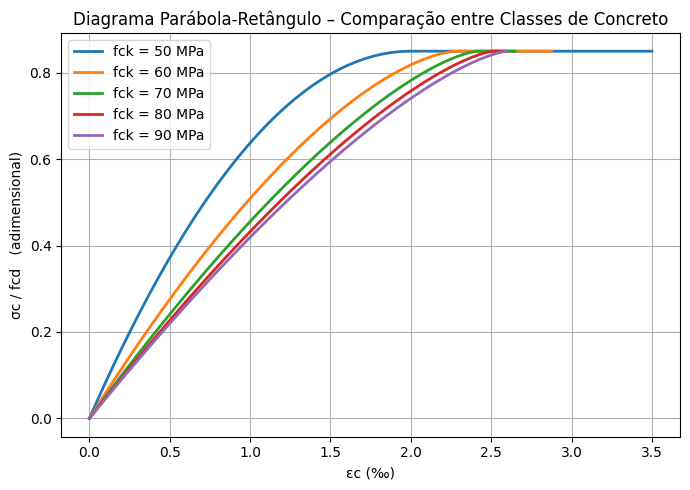

In [18]:
def parabola_retangulo(fck):
    if fck <= 50:
        eo, eu, n = 2.0, 3.5, 2.0
    else:
        eo = 2.0 + 0.085 * (fck - 50)**0.53
        eu = 2.6 + 35 * ((90 - fck) / 100)**4
        n  = 1.4 + 23.4 * ((90 - fck) / 100)**4
    return eo/1000, eu/1000, n      # converte ‰ → adimensional

def sig(ec, fck):
    eo, eu, n = parabola_retangulo(fck)
    ec2 = eo

    # garante que na parábola nunca entra ec > ec2
    ec_eff = np.minimum(ec, ec2)

    sig = 0.85*(1 - (1 - ec_eff/ec2)**n)
    sig = np.where(ec > ec2, 0.85, sig)   # patamar
    sig = np.where(ec > eu,  np.nan, sig) # corte na ruptura
    return sig


ec = np.linspace(0, 0.0035, 400)

plt.figure(figsize=(7,5))
for fck in [50,60,70,80,90]:
    plt.plot(ec*1000, sig(ec,fck), label=f"fck = {fck} MPa", linewidth=2)

plt.xlabel("εc (‰)")
plt.ylabel("σc / fcd   (adimensional)")
plt.title("Diagrama Parábola-Retângulo – Comparação entre Classes de Concreto")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### b) Diagrama bilinear

<figure style="text-align: center;">
    <img src="Bilinear.png" width="480">
    <figcaption><strong>Figura 2 –</strong> Diagrama tensão–deformação bilinear.</figcaption>
</figure>

Nesse diagrama, utiliza-se $\varepsilon_{01}$ como a deformação específica correspondente ao início do patamar plástico.  
Os valores recomendados são:

$$
\varepsilon_{01}\,(\text{‰}) =
\begin{cases}
1.75, 
& f_{ck} \le 50\ \text{MPa} \\[6pt]
1.75 + 0.55\left(\dfrac{f_{ck} - 50}{40}\right),
& f_{ck} > 50\ \text{MPa}
\end{cases}
$$

A deformação última $\varepsilon_u$ coincide com aquela adotada no diagrama parábola–retângulo, variando conforme a resistência do concreto.



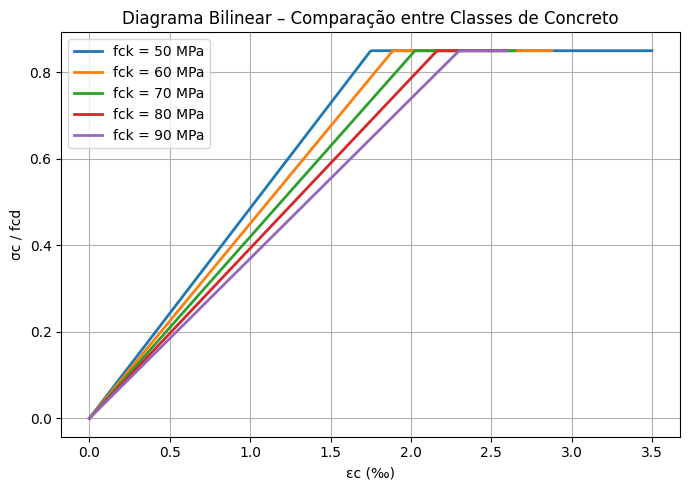

In [19]:
def bilinear(fck):
    if fck <= 50:
        eo, eu = 1.75, 3.5
    else:
        eo = 1.75 + 0.55*(fck-50)/40
        eu = 2.6 + 35*((90-fck)/100)**4
    return eo/1000, eu/1000          # converte ‰ → adimensional

def sig_bi(ec, fck):
    eo, eu = bilinear(fck)
    k = 0.85/eo
    sig = np.where(ec <= eo, k*ec, 0.85)      # linear até εo1
    sig = np.where(ec > eu, np.nan, sig)     # corta na ruptura
    return sig

ec = np.linspace(0, 0.004, 400)

plt.figure(figsize=(7,5))
for fck in [50,60,70,80,90]:
    plt.plot(ec*1000, sig_bi(ec,fck), label=f"fck = {fck} MPa", linewidth=2)

plt.xlabel("εc (‰)")
plt.ylabel("σc / fcd")
plt.title("Diagrama Bilinear – Comparação entre Classes de Concreto")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### c) Diagrama retangular

<figure style="text-align: center;">
    <img src="Retnagulo.png" width="480">
    <figcaption><strong>Figura 3 –</strong> Diagrama tensão–deformação retangular simplificado.</figcaption>
</figure>

Conforme se observa na figura, admite-se que a tensão no concreto seja igual a  
$\sigma_{cd} = \alpha_c f_{cd}$ desde a borda comprimida até uma distância $\lambda x$, sendo $x$ a profundidade da linha neutra.

O coeficiente $\alpha_c$ é dado por:


$$
\alpha_c =
\begin{cases}
0.85, 
& f_{ck} \le 50 \text{ MPa} \\[6pt]
0.85\left[1 - \dfrac{f_{ck} - 50}{200}\right],
& f_{ck} > 50 \text{ MPa}
\end{cases}
$$

Já o parâmetro $\lambda$ é definido como:

$$
\lambda =
\begin{cases}
0.80, 
& f_{ck} \le 50 \text{ MPa} \\[6pt]
0.80 - \dfrac{f_{ck} - 50}{400},
& f_{ck} > 50 \text{ MPa}
\end{cases}
$$


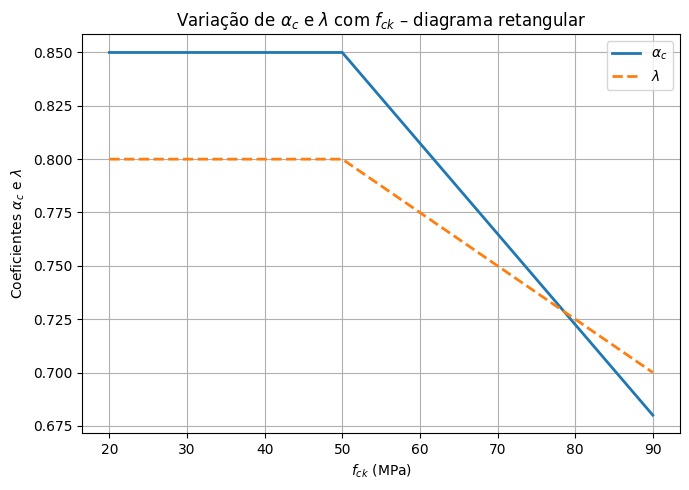

In [20]:
def retangular(fck):
    if fck <= 50:
        alfac = 0.85
        lbd   = 0.80
    else:
        alfac = 0.85 * (1 - (fck - 50)/200)
        lbd   = 0.80 - (fck - 50)/400
    return alfac, lbd

fck_vals = np.linspace(20, 90, 71)
alfas, lambdas = [], []

for f in fck_vals:
    a, l = retangular(f)
    alfas.append(a)
    lambdas.append(l)

plt.figure(figsize=(7,5))
plt.plot(fck_vals, alfas,  label=r"$\alpha_c$", linewidth=2)
plt.plot(fck_vals, lambdas, label=r"$\lambda$", linewidth=2, linestyle="--")
plt.xlabel(r"$f_{ck}$ (MPa)")
plt.ylabel(r"Coeficientes $\alpha_c$ e $\lambda$")
plt.title(r"Variação de $\alpha_c$ e $\lambda$ com $f_{ck}$ – diagrama retangular")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### d) Comentários sobre os diagramas

Nesta seção serão apresentadas três figuras complementares. A primeira ilustra a sobreposição entre os diagramas Parábola-Retângulo e bilinear, permitindo visualizar de forma direta as diferenças no comportamento tensão–deformação. A segunda mostra a comparação entre as áreas sob as curvas correspondentes aos diferentes modelos, evidenciando como cada diagrama representa a capacidade resistente em função da deformação máxima. A terceira apresenta a relação entre os diagramas, destacando as proporções Bilinear/Parábola e Retangular/Parábola, de modo a facilitar a interpretação comparativa entre os modelos adotados.

In [21]:

# -------------------------------------------------------------------
# Diagramas material adimensionais σ̃(εc) para o concreto
# -------------------------------------------------------------------

def diag_para(eps, fck):
    """
    Diagrama parábola-retângulo em termos de σ̃(εc).
    eps em ‰, array numpy.
    """
    eps = np.asarray(eps, dtype=float)

    if fck <= 50.0:
        ec2 = 2.0     # ‰
        eu  = 3.5     # ‰
        n   = 2.0
        alfac = 0.85
    else:
        eo  = 2.0 + 0.085 * (fck - 50.0)**0.53
        eu  = 2.6 + 35.0 * ((90.0 - fck)/100.0)**4
        n   = 1.4 + 23.4 * ((90.0 - fck)/100.0)**4
        ec2 = eo
        alfac = 0.85 * (1.0 - (fck - 50.0)/200.0)

    eps_clipped = np.clip(eps, 0.0, eu)
    eps_eff = np.minimum(eps_clipped, ec2)

    sig_tilde = alfac*(1.0 - (1.0 - eps_eff/ec2)**n)
    sig_tilde = np.where(eps_clipped > 0.0, sig_tilde, 0.0)

    return sig_tilde, eu


def diag_bili(eps, fck):
    """
    Diagrama bilinear em termos de σ̃(εc).
    eps em ‰, array numpy.
    """
    eps = np.asarray(eps, dtype=float)

    if fck <= 50.0:
        e01 = 1.75    # ‰
        eu  = 3.50    # ‰
        alfac = 0.85
    else:
        e01 = 1.75 + 0.55 * (fck - 50.0) / 40.0
        eu  = 2.6 + 35.0 * ((90.0 - fck)/100.0)**4
        alfac = 0.85 * (1.0 - (fck - 50.0)/200.0)

    eps_clipped = np.clip(eps, 0.0, eu)

    sig_tilde = alfac * np.where(eps_clipped <= 0.0, 0.0,
                         np.where(eps_clipped <= e01,
                                  eps_clipped / e01,
                                  1.0))

    return sig_tilde, eu


def diag_reta(eps, fck):
    """
    Diagrama retangular idealizado: σ̃ = 1 para εc > 0 até εu.
    Aqui uso o mesmo εu do Eurocode/NBR para fck.
    """
    eps = np.asarray(eps, dtype=float)

    if fck <= 50.0:
        eu = 3.5
        alfac = 0.85
    else:
        # mesma expressão de eu dos outros diagramas
        eu = 2.6 + 35.0 * ((90.0 - fck)/100.0)**4
        alfac = 0.85 * (1.0 - (fck - 50.0)/200.0)


    eps_clipped = np.clip(eps, 0.0, eu)
    sig_tilde = alfac * np.where(eps_clipped > 0.0, 1.0, 0.0)

    return sig_tilde, eu


O gráfico do código a seguir ilustra, de forma direta, como diferentes modelos de representação do comportamento tensão–deformação do concreto respondem ao acréscimo de deformação. O diagrama parábola-retângulo apresenta uma evolução contínua da tensão até atingir o patamar máximo, refletindo de maneira mais fiel o comportamento real do concreto, cuja rigidez vai diminuindo gradualmente à medida que a deformação cresce. Já o diagrama bilinear simplifica essa resposta em duas fases: um trecho inicial linear, que assume rigidez constante, seguido de um patamar horizontal que representa a tensão máxima. A comparação entre as duas curvas mostra que o modelo bilinear tende a subestimar as tensões no início e a superestimá-las levemente próximo ao trecho final, destacando as diferenças de precisão e de aplicação prática entre cada idealização. Essa visualização permite ao estudante compreender como a escolha do diagrama influencia análises estruturais e avaliações de capacidade resistente.

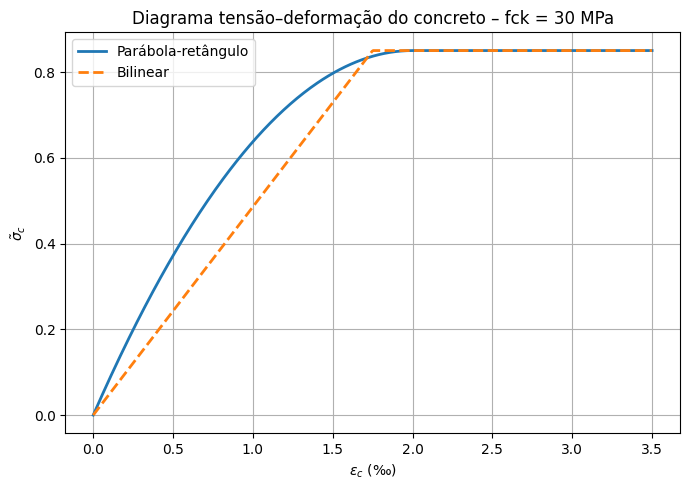

In [22]:
# ===========================================================
# 1.2.d – Gráfico σ̃ × εc: sobreposição parábola-retângulo e bilinear
# ===========================================================

fck_plot = 30.0   # ajuste se quiser

# uso o eu da parábola como limite de deformação do gráfico
_, eu_para = diag_para(0.0, fck_plot)
eps_vals = np.linspace(0.0, eu_para, 500)

sig_para, _ = diag_para(eps_vals, fck_plot)
sig_bili, _ = diag_bili(eps_vals, fck_plot)

plt.figure(figsize=(7, 5))
plt.plot(eps_vals, sig_para, label="Parábola-retângulo", linewidth=2)
plt.plot(eps_vals, sig_bili, label="Bilinear", linewidth=2, linestyle="--")
plt.xlabel(r"$\varepsilon_c$ (‰)")
plt.ylabel(r"$\tilde{\sigma}_c$")
plt.title(f"Diagrama tensão–deformação do concreto – fck = {fck_plot:.0f} MPa")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

O gráfico a seguir apresenta a evolução da área sob os três diagramas tensão–deformação em função da deformação máxima considerada, para fck = 30 MPa. Essa área pode ser interpretada, de forma simplificada, como uma medida da “capacidade resistente acumulada” do concreto à compressão até um determinado nível de deformação. Nota-se que o diagrama retangular, mesmo após a correção pelo fator λ [é possível editar a função lambda_fck para retornar valores e verificar o que acontece com a curva], gera as maiores áreas ao longo de praticamente todo o intervalo analisado, refletindo o caráter mais conservador dessa idealização em termos de capacidade resistente. O diagrama bilinear, por sua vez, tende a produzir as menores áreas, sobretudo para deformações intermediárias, devido ao modelo assumir um crescimento linear da tensão até atingir o patamar máximo. Já o diagrama parábola-retângulo ocupa uma posição intermediária, aproximando-se do bilinear para pequenas deformações e convergindo gradualmente para o retangular à medida que a deformação aumenta.

Convém destacar que, em uma análise de flexão, a área sob o diagrama representa a força de compressão mobilizada pelo concreto conforme o modelo tensão–deformação adotado. No contexto específico deste gráfico, como o valor de `ε_c` corresponde à deformação máxima da seção analisada, a interpretação se limita ao domínio 2a — no qual a região comprimida ainda não alcançou a plastificação — e ao domínio 2b - no qual apenas a fibra mais comprimida atinge a deformação limite associada ao início da ruptura do concreto - caracterizando a transição entre os domínios 2 e 3.

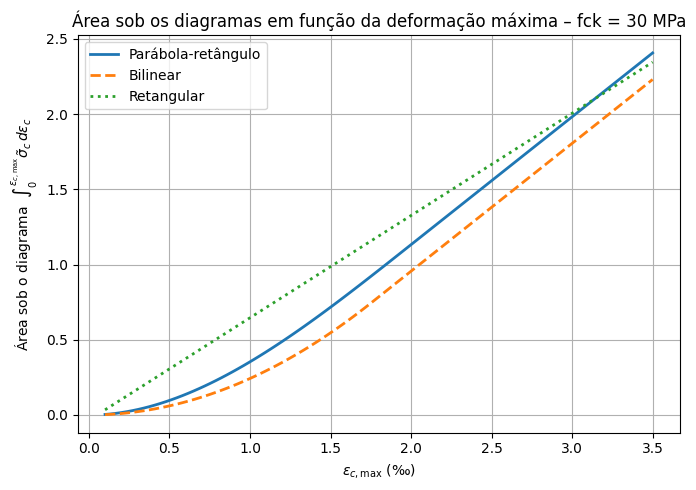

In [23]:
# ===========================================================
# Áreas sob as curvas × deformação máxima
# ===========================================================
def lambda_fck(fck):
    if fck <= 50.0:
        return 0.80
    else:
        return 0.80 - (fck - 50.0) / 400.0


fck_plot = 30.0
lam = lambda_fck(fck_plot)

# pego um eu "global" como o mínimo entre os três (para garantir domínio comum)
_, eu_para = diag_para(0.05, fck_plot)
_, eu_bili = diag_bili(0.05, fck_plot)
_, eu_reta = diag_reta(0.05, fck_plot)
eu_global = min(eu_para, eu_bili, eu_reta)

eps_max_vals = np.linspace(0.1, eu_global, 100)   # começa em 0.1‰ só para evitar zero exato

area_para = []
area_bili = []
area_reta = []

for eps_max in eps_max_vals:
    eps = np.linspace(0.05, eps_max, 1000)

    sig_p, _ = diag_para(eps, fck_plot)
    sig_b, _ = diag_bili(eps, fck_plot)
    sig_r, _ = diag_reta(eps, fck_plot)

    area_para.append(np.trapz(sig_p, eps))
    area_bili.append(np.trapz(sig_b, eps))
    area_reta.append(lam*np.trapz(sig_r, eps))

area_para = np.array(area_para)
area_bili = np.array(area_bili)
area_reta = np.array(area_reta)

plt.figure(figsize=(7, 5))
plt.plot(eps_max_vals, area_para, label="Parábola-retângulo", linewidth=2)
plt.plot(eps_max_vals, area_bili, label="Bilinear", linewidth=2, linestyle="--")
plt.plot(eps_max_vals, area_reta, label="Retangular", linewidth=2, linestyle=":")
plt.xlabel(r"$\varepsilon_{c,\max}$ (‰)")
plt.ylabel(r"Área sob o diagrama  $\int_0^{\varepsilon_{c,\max}} \tilde{\sigma}_c \, d\varepsilon_c$")
plt.title(f"Área sob os diagramas em função da deformação máxima – fck = {fck_plot:.0f} MPa")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


O gráfico a seguir apresenta a razão entre as áreas sob os diagramas bilinear e retangular em relação ao diagrama parábola–retângulo, em função da deformação máxima `ε_{c,\max}`. Como a área sob cada curva representa a força de compressão mobilizada pelo concreto até determinado nível de deformação, essas razões permitem avaliar o quanto cada idealização simplificada se aproxima do comportamento mais realista descrito pelo diagrama parábola–retângulo.

A razão bilinear/parábola–retângulo mantém-se levemente abaixo de 1 em todo o intervalo analisado, indicando que o diagrama bilinear tende a subestimar a força resistente. Essa diferença é mais evidente em baixas deformações, reduzindo-se gradualmente até se aproximar da unidade à medida que `ε_{c,\max}` aumenta.

Já a razão retangular/parábola–retângulo inicia com valores bastante elevados nas pequenas deformações, o que revela uma superestimação significativa da resistência quando se adota o diagrama retangular para pequenas deformações. Com o aumento da deformação máxima, essa razão diminui de forma contínua até convergir para valores próximos de 1, mostrando que a idealização retangular torna-se mais compatível com o comportamento da parábola–retângulo quanto mais próxima a seção se aproximar do domínio 3.


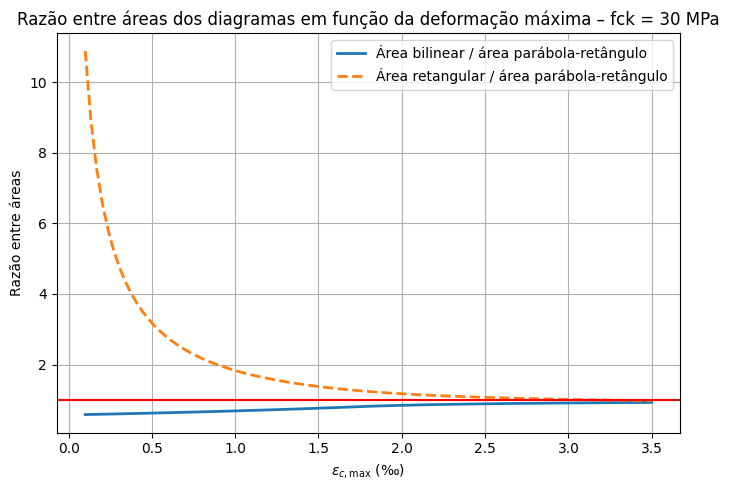

In [24]:
# ===========================================================
# Razões entre áreas: (Bilinear/Parábola) e (Retangular/Parábola)
# ===========================================================

# evita divisão por zero; como começamos em 0.1‰, area_para já é > 0,
# mas deixo a máscara por segurança
mask = area_para > 0.0

eps_ratio   = eps_max_vals[mask]
ratio_bili  = area_bili[mask] / area_para[mask]
ratio_reta  = area_reta[mask] / area_para[mask]

plt.figure(figsize=(7, 5))
plt.plot(eps_ratio, ratio_bili, label="Área bilinear / área parábola-retângulo", linewidth=2)
plt.plot(eps_ratio, ratio_reta, label="Área retangular / área parábola-retângulo", linewidth=2, linestyle="--")

plt.axhline(1.0, color="red", linewidth=1.5)  # linha de referência

plt.xlabel(r"$\varepsilon_{c,\max}$ (‰)")
plt.ylabel("Razão entre áreas")
plt.title(f"Razão entre áreas dos diagramas em função da deformação máxima – fck = {fck_plot:.0f} MPa")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 1.3 DEMAIS HIPÓTESES

### a) Módulo de Elasticidade do Aço
<figure style="text-align: center;">
    <img src="Aço.png" width="480">
    <figcaption><strong>Figura 3 –</strong> Diagrama tensão–deformação retangular simplificado.</figcaption>
</figure>

Para o diagrama de tensão–deformação do aço, considera-se o gráfico bilinear conforme apresentado na figura. No entanto, o autor adota o módulo de elasticidade como sendo $E_s = 200 \, \text{GPa}$ diferentemente do valor recomendado pela NBR 6118 $E_s = 210 \, \text{GPa}$.

Essa diferença gera uma leve alteração no valor considerado para o escoamento do aço, $\varepsilon_{yd}$ , e consequentemente na posição da linha neutra no ponto que define a fronteira entre os domínios 3 e 4 (em torno de 2%).

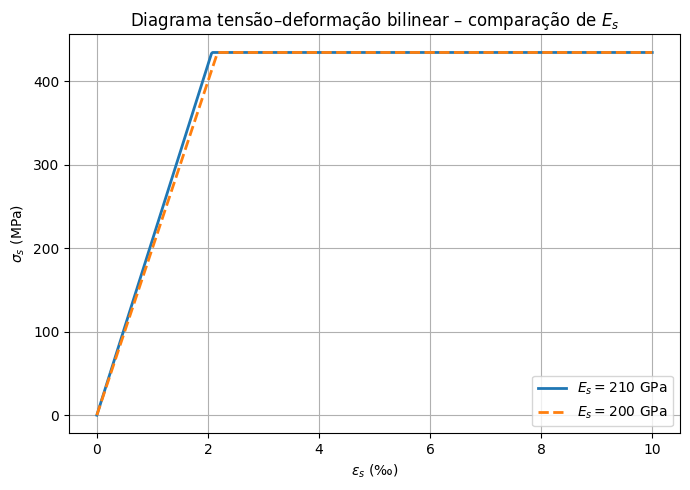

       Es epsilon_yd (‰)       C50       C60       C70       C80       C90
  200 GPa       2.173913  0.616858  0.571551   0.55397  0.544627  0.544627
  210 GPa       2.070393  0.628322  0.583455  0.565991  0.556698  0.556698
Diferença                    1.82%     2.04%     2.12%     2.17%     2.17%


In [25]:
# dados do aço
fyk = 500.0               # MPa
gamma_s = 1.15
fyd = fyk / gamma_s       # MPa
eps_u = 10/1000           # 10 ‰

def diagrama_aco(Es_GPa):
    Es = Es_GPa * 1000.0                    # MPa
    eps_yd = fyd / Es                       # deformação de escoamento (adimensional)
    eps = np.linspace(0, eps_u, 500)
    sig = np.where(eps <= eps_yd, Es*eps, fyd)
    return eps, sig, eps_yd

# curvas para 210 e 200 GPa
eps_210, sig_210, eps_yd_210 = diagrama_aco(210)
eps_200, sig_200, eps_yd_200 = diagrama_aco(200)

plt.figure(figsize=(7,5))
plt.plot(eps_210*1000, sig_210, label=r"$E_s = 210$ GPa", linewidth=2)
plt.plot(eps_200*1000, sig_200, label=r"$E_s = 200$ GPa", linewidth=2, linestyle="--")

plt.xlabel(r"$\varepsilon_s$ (‰)")
plt.ylabel(r"$\sigma_s$ (MPa)")
plt.title("Diagrama tensão–deformação bilinear – comparação de $E_s$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Tabela comparativa
# ---------------------------------------------------------

eu_list = [3.5, 2.9, 2.7, 2.6, 2.6]   # valores de εu (‰) – C50, C60, C70, C80, C90
classes = ["C50", "C60", "C70", "C80", "C90"]

eps_yd_210_mil = eps_yd_210 * 1000   # em ‰
eps_yd_200_mil = eps_yd_200 * 1000   # em ‰

xi_200 = [eu/(eu + eps_yd_200_mil) for eu in eu_list]
xi_210 = [eu/(eu + eps_yd_210_mil) for eu in eu_list]
dif_pct = [(x210 - x200)/x210*100 for x200, x210 in zip(xi_200, xi_210)]

df = pd.DataFrame(
    {
        "Es": ["200 GPa", "210 GPa", "Diferença"],
        "epsilon_yd (‰)": [eps_yd_200_mil, eps_yd_210_mil, ""],
        **{
            cls: [round(x200, 6), round(x210, 6), f"{d:.2f}%" ]
            for cls, x200, x210, d in zip(classes, xi_200, xi_210, dif_pct)
        }
    }
)

print(df.to_string(index=False))


### b) Posição da linha neutra

<figure style="text-align: center;">
    <img src="LinhaNeutra.png" width="480">
    <figcaption><strong>Figura 3 –</strong> Diagrama tensão–deformação retangular simplificado.</figcaption>
</figure>

Para garantir uma boa ductilidade da peça, as normas de projeto limitam a profundidade da linha neutra a:

$$
x \le x_{\text{lim}}
$$

Elimina-se, assim, a parte final do domínio 3, onde a deformação na armadura mais tracionada é muito próxima da deformação de escoamento.  

Por esse motivo, o dimensionamento à flexão simples fica restrito ao domínio 2 e à parte inicial do domínio 3, como ilustrado na figura e expresso pelas equações abaixo.


$$
x_{\text{lim}} =
\begin{cases}
0{.}45, & \text{se } f_{ck} \le 50\ \text{MPa} \\[6pt]
0{.}35, & \text{se } f_{ck} > 50\ \text{MPa}
\end{cases}
$$

In [26]:
def xmax(fck):
    if fck <= 50:
        xlim = 0.45
    else:
        xlim = 0.35
    return xlim

### c) Armadura mínima

#### Armadura mínima entre os Estádios I e II

A definição de uma armadura mínima não decorre apenas do dimensionamento ao Estado Limite Último, mas também da necessidade de evitar uma ruptura brusca durante a transição do Estádio I (seção não fissurada) para o Estádio II (seção fissurada). Segundo José Milton Araújo, a verificação inicia-se pela resistência à tração da seção no Estádio I.

#### Estádio I

<figure style="text-align: center;">
    <img src="EstadioI.png" width="480">
    <figcaption><strong>Figura 4 –</strong> Seção de concreto simples no estádio I</figcaption>
</figure>

A resultante resistente à tração é:

$\displaystyle R_{ct}=\frac{(b\,h/2)\,\sigma_{ct}}{2}
=\frac{b\,h\,\sigma_{ct}}{4}$

Adotando-se o braço de alavanca $Z_1=\frac{2h}{3}$, o momento resistente torna-se:

$\displaystyle M_r=\frac{b\,h^2\,f_{ct}}{6}$

#### Estádio II

<figure style="text-align: center;">
    <img src="EstadioII.png" width="480">
    <figcaption><strong>Figura 5 –</strong> Seção de concreto armado no estádio II</figcaption>
</figure>

A área mínima de armadura é calculada por:

$\displaystyle A_{s,\min}=\frac{M_r}{Z_2\,f_{yd}}
=\frac{b\,h^2\,f_{ct}}{6\,Z_2\,f_{yd}}$

Como se adota $Z_2=\frac{5h}{6}$:

$\displaystyle A_{s,\min}=\frac{b\,h^2\,f_{ct}}{6\,(5h/6)\,f_{yd}}
=\frac{f_{ct}\,b\,h}{5\,f_{yd}}$

Definindo $A_c=b\,h$, $\rho=A_s/A_c$ e adotando  
$f_{ct}=f_{ctk,\text{sup}}=1{,}3\,f_{ctm}$ com:

$\displaystyle 
f_{ctm}=
\begin{cases}
0{,}3\,f_{ck}^{2/3}, & f_{ck}\leq 50\;\text{MPa} \\
2{,}12\,\ln(1+0{,}11f_{ck}), & f_{ck}\geq 55\;\text{MPa}
\end{cases}
$

obtém-se:

$\displaystyle 
\rho_{\min}=
\begin{cases}
\dfrac{0{,}078\,f_{ck}^{2/3}}{f_{yd}}, & f_{ck}\leq 50\;\text{MPa}\\[6pt]
\dfrac{0{,}5512\,\ln(1+0{,}11f_{ck})}{f_{yd}}, & f_{ck}\geq 55\;\text{MPa}
\end{cases}
$

---

#### Proposta da NBR 6118

A norma define o momento mínimo:

$\displaystyle M_{d,\min}=0{,}8\,W_0\,f_{ctk,\text{sup}}$

Para uma seção retangular, com os parâmetros adimensionais de Carvalho (2014):

$\displaystyle K_{MD}=\frac{M_d}{b_w\,d^2\,f_{cd}}$

$\displaystyle 
K_x=\frac{1-\sqrt{1-\frac{2\,K_{MD}}{\alpha_c}}}{\lambda}
=\frac{1-\sqrt{1-\frac{2\,M_d}{b_w\,d^2\,f_{cd}\,\alpha_c}}}{\lambda}
$

$\displaystyle 
K_z=1-\frac{\lambda}{2}K_x
=\frac{1}{2}+\frac{1}{2}\sqrt{1-\frac{2\,M_d}{b_w\,d^2\,f_{cd}\,\alpha_c}}
$

A área de aço é:

$\displaystyle A_s=\frac{M_d}{K_z\,d\,f_{yd}}$

Substituindo $M_d=0{,}8\,b\,h^2\,f_{ctk,\text{sup}}/6$ e tomando $b=h=1$:

$\displaystyle
\rho_s=
\frac{f_{ctk,\text{sup}}}{
\left(
\frac12+
\frac12\sqrt{
1-\frac{1{,}6\,f_{ctk,\text{sup}}}{3{,}84\,f_{cd}\,\alpha_c}
}
\right)
6\,f_{yd}}
$

---

#### Comparação entre versões da NBR 6118

As taxas mínimas de armadura prescritas pelas versões 2014 e 2023 da NBR 6118 são inferiores às propostas na edição 2003. Embora a origem precisa dos valores da edição antiga não seja explícita, o índice $\omega=0{,}035$ para seções retangulares sugere que os valores possam ter sido obtidos por ábacos como os de Montoya e Venturini.

Assim, considerando:

$\displaystyle \omega=\frac{A_s\,f_{yd}}{A_c\,f_{cd}}$

tem-se:

$\displaystyle \rho_{\min}=\frac{A_s}{A_c}
=\frac{f_{cd}\,\omega}{f_{yd}}
$


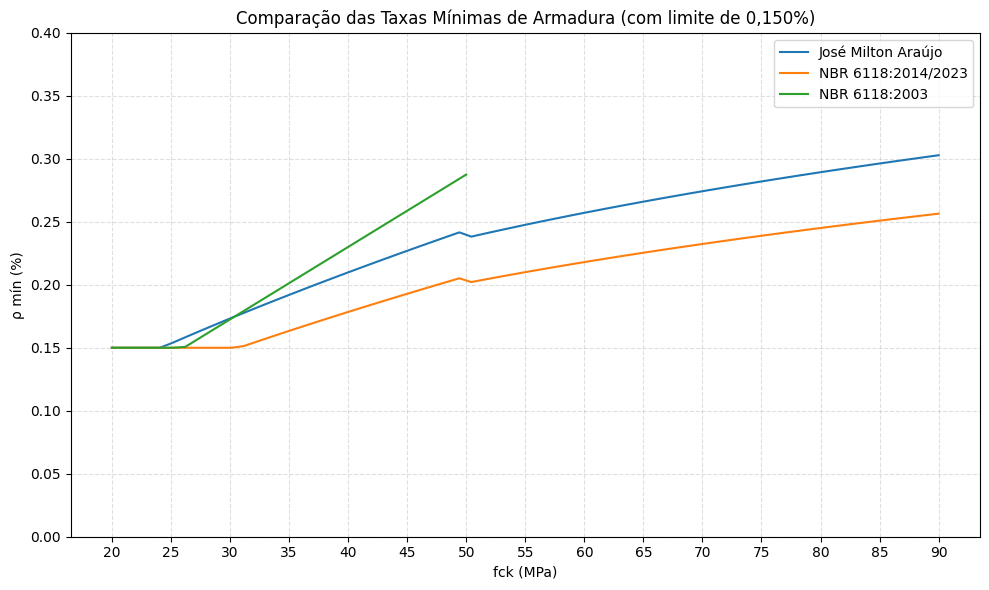

In [27]:
def amin_jma(fck):
    fyd = 500 / 1.15
    if fck <= 50:
        rho = 0.078 * fck**(2/3) / fyd
    else:
        rho = 0.5512 * np.log(1 + 0.11 * fck) / fyd
    return max(rho, 0.00150)

def amin_2014(fck):
    fyd = 500 / 1.15
    fcd = fck / 1.4

    if fck <= 50:
        fctm = 0.3 * fck**(2/3)
        fctksup = 1.3 * fctm
        alfac = 0.85
    else:
        fctm = 2.12 * np.log(1 + 0.11 * fck)
        fctksup = 1.3 * fctm
        alfac = 0.85 * (1 - (fck - 50) / 200)

    termoraiz = 1 - (1.6 * fctksup) / (3.84 * fcd * alfac)
    kz = 0.5 + 0.5 * math.sqrt(termoraiz)

    rho = fctksup / (kz * 6 * fyd)
    return max(rho, 0.00150)

def amin_2003(fck):
    fcd = fck / 1.4
    fyd = 500 / 1.15
    rho = 0.035 * fcd / fyd
    return max(rho, 0.00150)

# Vetorização das funções
v_amin_jma = np.vectorize(amin_jma)
v_amin_2014 = np.vectorize(amin_2014)
v_amin_2003 = np.vectorize(amin_2003)

# Faixas de fck
fck_vals1 = np.linspace(20, 90, 70)
fck_vals2 = np.linspace(20, 50, 30)

# Cálculo das três curvas (em %)
asjoma = v_amin_jma(fck_vals1) * 100
as2014 = v_amin_2014(fck_vals1) * 100
as2003 = v_amin_2003(fck_vals2) * 100

# Plot
plt.figure(figsize=(10,6))
plt.plot(fck_vals1, asjoma, label="José Milton Araújo")
plt.plot(fck_vals1, as2014, label="NBR 6118:2014/2023")
plt.plot(fck_vals2, as2003, label="NBR 6118:2003")

plt.xlabel("fck (MPa)")
plt.ylabel("ρ mín (%)")
plt.title("Comparação das Taxas Mínimas de Armadura (com limite de 0,150%)")

# Grades customizadas
plt.grid(True, which="both", linestyle="--", alpha=0.4)

# Grid no eixo x a cada 5 MPa
plt.xticks(np.arange(20, 95, 5))

# Grid no eixo y a cada 0,05%
plt.yticks(np.arange(0.0, max(asjoma.max(), as2014.max(), as2003.max()) + 0.1, 0.05))

plt.legend()
plt.tight_layout()
plt.show()



## 1.4 DETERMINAÇÃO DO MOMENTO LIMITE

### a) Compressão Limite No Concreto

A resultante de compressão no concreto (rcc) é valor adimensional correspondente à parcela comprimida da seção em análise. 

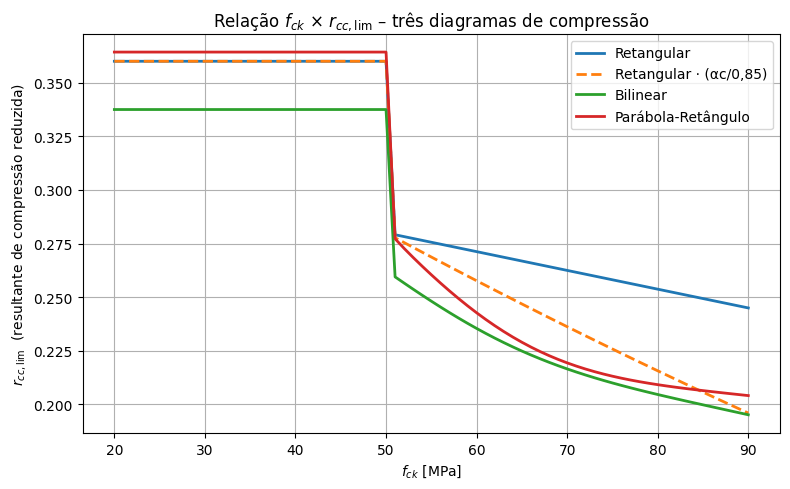

In [28]:
# ------------------------------
# Curva 1 - Retangular
# ------------------------------

def retangular(fck):
    if fck <= 50:
        alfac = 0.85
        lbd   = 0.80
    else:
        alfac = 0.85 * (1 - (fck - 50)/200)
        lbd   = 0.80 - (fck - 50)/400
    return alfac, lbd

def mdlim_ret(fck):
    alfac, l0 = retangular(fck)
    csi_lim   = xmax(fck)
    rcc_lim   = l0 * csi_lim
    mi_lim    = l0 * csi_lim * (1 - 0.5 * l0 * csi_lim)
    return csi_lim, rcc_lim, mi_lim

# ------------------------------
# Curva 2 - Bilinear
# ------------------------------

def bilinear(fck):
    if fck <= 50:
        eo = 1.75      # ‰
        eu = 3.50      # ‰
    else:
        eo = 1.75 + 0.55 * (fck - 50) / 40
        eu = 2.6 + 35 * ((90 - fck) / 100)**4
    return eo/1000, eu/1000   

def mdlim_bili(fck):
    eo, eu = bilinear(fck)

    csi_lim = xmax(fck)
    csi_0   = eo / eu
    l0      = 1 - csi_0

    rc1 = 0.5 * (1 - l0) * csi_lim
    rc2 = l0   * csi_lim
    rcc_lim = rc1 + rc2

    mi_c1 = rc1 * (1 - (1 + 2*l0) * csi_lim / 3)
    mi_c2 = rc2 * (1 - 0.5 * l0 * csi_lim)
    mi_lim = mi_c1 + mi_c2

    return csi_lim, rcc_lim, mi_lim


# ------------------------------
# Curva 3 - Parábola-Retângulo
# ------------------------------

def parabola_retangulo(fck):
    if fck <= 50:
        eo = 2.0       # ‰
        eu = 3.5       # ‰
        n1 = 2.0
    else:
        eo = 2.0 + 0.085 * (fck - 50)**0.53
        eu = 2.6 + 35 * ((90 - fck) / 100)**4
        n1 = 1.4 + 23.4 * ((90 - fck) / 100)**4
    return eo, eu, n1   # também em adimensional

def mdlim_parret(fck):
    eo, eu, n1 = parabola_retangulo(fck)

    csi_lim = xmax(fck)
    csi_0   = eo / eu
    l0      = 1 - csi_0

    rc1 = csi_0 * csi_lim * n1 / (n1 + 1)
    rc2 = l0 * csi_lim
    rcc_lim = rc1 + rc2

    mi_c1 = (csi_0 * csi_lim * (1 - csi_lim) * n1 / (n1 + 1)
             + (csi_0 * csi_lim)**2 * (0.5 - 1 / ((n1 + 1) * (n1 + 2))))
    mi_c2 = l0 * csi_lim * (1 - 0.5 * l0 * csi_lim)
    md_lim = mi_c1 + mi_c2

    return csi_lim, rcc_lim, rc1, rc2, md_lim

# ------------------------------
# Gráfico: fck × compressão máxima r_cc,lim
# com curva retangular ajustada por (αc / 0,85)
# ------------------------------

fck_vals = np.linspace(20, 90, 71)

rcc_ret_vals      = []
rcc_ret_alf_vals  = []
rcc_bili_vals     = []
rcc_pare_vals     = []

for fck in fck_vals:
    # retangular original
    alfac, lbd = retangular(fck)
    csi_lim    = xmax(fck)
    rcc_r      = lbd * csi_lim

    # retangular ajustado pela razão αc / 0,85
    rcc_r_alf  = rcc_r * (alfac / 0.85)

    # bilinear e parábola-retângulo
    _, rcc_b, _           = mdlim_bili(fck)
    _, rcc_p, _, _, _     = mdlim_parret(fck)

    rcc_ret_vals.append(rcc_r)
    rcc_ret_alf_vals.append(rcc_r_alf)
    rcc_bili_vals.append(rcc_b)
    rcc_pare_vals.append(rcc_p)

plt.figure(figsize=(8,5))
plt.plot(fck_vals, rcc_ret_vals,      label="Retangular", linewidth=2)
plt.plot(fck_vals, rcc_ret_alf_vals,  label="Retangular · (αc/0,85)", linewidth=2, linestyle="--")
plt.plot(fck_vals, rcc_bili_vals,     label="Bilinear",   linewidth=2)
plt.plot(fck_vals, rcc_pare_vals,     label="Parábola-Retângulo", linewidth=2)

plt.xlabel(r"$f_{ck}$ [MPa]")
plt.ylabel(r"$r_{cc,\mathrm{lim}}$  (resultante de compressão reduzida)")
plt.title(r"Relação $f_{ck}$ × $r_{cc,\mathrm{lim}}$ – três diagramas de compressão")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### b) Momento Limite

O momento limite, assim como o valor de compressão limite, é o valor adimensional correspondente ao momento resistido pela seção em análise. 

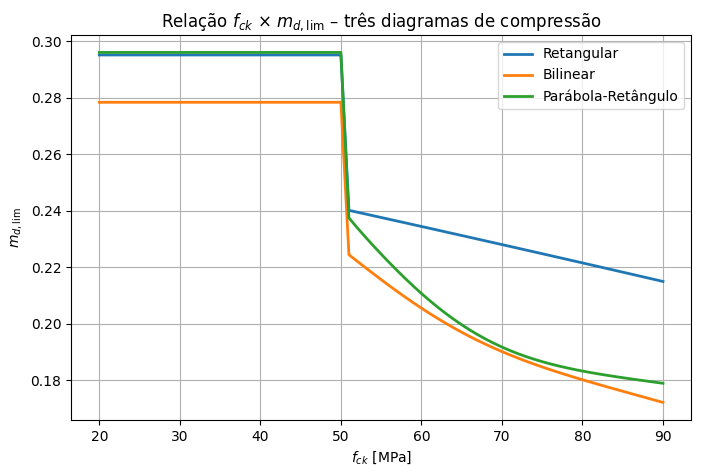

In [29]:
# ------------------------------
# Gráfico: fck × momento reduzido
# ------------------------------

fck_vals = np.linspace(20, 90, 71)

mi_ret_vals  = []
mi_bili_vals = []
mi_pare_vals = []

for fck in fck_vals:
    _, _, mi_r   = mdlim_ret(fck)
    _, _, mi_bi  = mdlim_bili(fck)
    _, _, _, _, mi_pr = mdlim_parret(fck)   # agora desempacota os 5 valores

    mi_ret_vals.append(mi_r)
    mi_bili_vals.append(mi_bi)
    mi_pare_vals.append(mi_pr)

plt.figure(figsize=(8,5))
plt.plot(fck_vals, mi_ret_vals,  label="Retangular", linewidth=2)
plt.plot(fck_vals, mi_bili_vals, label="Bilinear",   linewidth=2)
plt.plot(fck_vals, mi_pare_vals, label="Parábola-Retângulo", linewidth=2)

plt.xlabel(r"$f_{ck}$ [MPa]")
plt.ylabel(r"$m_{d,\mathrm{lim}}$")
plt.title(r"Relação $f_{ck}$ × $m_{d,\mathrm{lim}}$ – três diagramas de compressão")
plt.grid(True)
plt.legend()
plt.show()

## 1.5 DIMENSIONAMENTO COM ARMADURA SIMPLES

Se o momento fletor solicitante de cálculo for menor ou igual ao momento limite, o dimensionamento é feito com armadura simples e a seção será subarmada ou normalmente armada. A profundidade da linha neutra será menor ou igual a xlim e a ruína ocorrerá no domínio 2 ou 3.

## 1.6 Dimensionamento com Armadura Dupla

Se o momento fletor solicitante de cálculo for maior que o momento limite, a profundidade da linha neutra é fixada como sendo igual a $x_{\text{lim}}$, acrescentando-se uma armadura de compressão com área $A_s'$.

Considerando:

$$
x_{\text{lim}} = \zeta_{\text{lim}}\, d
$$

$$
\delta = \frac{d'}{d}
$$

Então:

$$
\varepsilon_s' = 
\varepsilon_u \left( \frac{\zeta_{\text{lim}} - \delta}{\zeta_{\text{lim}}} \right)
$$

Fazendo o equilíbrio de momentos em relação ao centróide da armadura tracionada, resulta:

$$
M_d - R'_{sd}(d - d') - R_{cc,\text{lim}}\, z_{\text{lim}} = 0
$$

$$
A_s' =
\frac{M_d - M_{d,\text{lim}}}{(d - d')\, \sigma'_{sd}}
$$

Definindo a taxa de armadura:

$$
\rho' = \frac{A_s'}{b\, d}
$$

e introduzindo os adimensionais, chega-se a:

$$
\rho' =
\frac{(\mu - \mu_{\text{lim}})\, \sigma_{cd}}
{(1 - \delta)\, \sigma'_{sd}}
$$

Para o equilíbrio das forças:

$$
R_{sd} = R'_{sd} + R_{cc,\text{lim}}
$$

e

$$
A_s =
\frac{
A_s'\, \sigma_{sd}
+
R_{cc,\text{lim}}\, b\, d\, \sigma_{cd}
}{
f_{yd}
}
$$

Definindo a taxa de armadura como sendo:

$$
\rho = \frac{A_s}{b\, d}
$$

obtém-se:

$$
\rho =
\left(
r_{cc,\text{lim}}
+
\frac{\mu - \mu_{\text{lim}}}{1 - \delta}
\right)
\left(
\frac{\sigma_{cd}}{f_{yd}}
\right)
$$


## 1.7 RESULTADOS OBTIDOS COM OS TRÊS DIAGRAMAS PARA O CONCRETO

#### Comparação da posição da linha neutra em função do momento atuante;

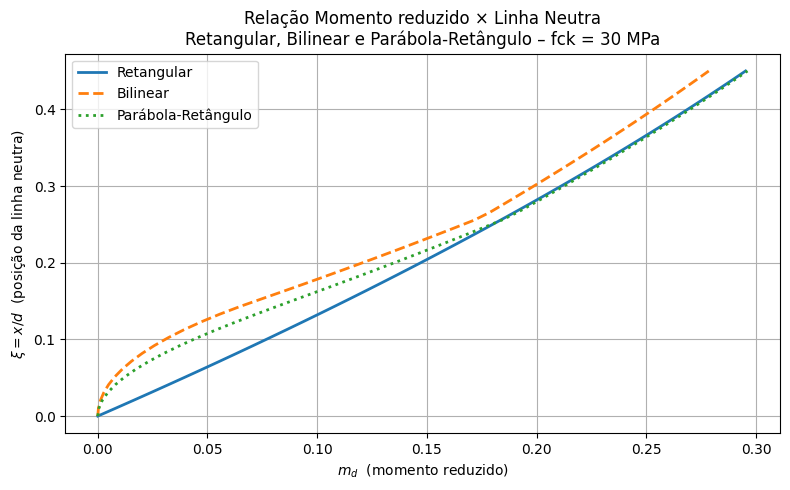

In [30]:
# ----------------------------------------------------------------------
# Função do momento reduzido m_d(x) para o diagrama retangular
# ----------------------------------------------------------------------
def md_reta(x, fck):
    if fck <= 50:
        lbd = 0.80
    else:
        lbd = 0.80 - ((fck - 50) / 400)
    mi_reta = lbd * x * (1 - 0.5 * lbd * x)
    return mi_reta

# ----------------------------------------------------------------------
# Função do momento reduzido m_d(x) para o diagrama bilinear
# ----------------------------------------------------------------------
def md_bili(x, fck):
    # parâmetros do diagrama bilinear
    if fck <= 50.0:
        e01 = 1.75   # ‰ – início do patamar
        eu  = 3.50   # ‰ – deformação última
    else:
        e01 = 1.75 + 0.55 * (fck - 50.0) / 40.0
        eu  = 2.6 + 35.0 * ((90.0 - fck) / 100.0)**4

    # proteção para valores extremos de x
    if x <= 0.0:
        return 0.0
    if x >= 1.0:
        x = 0.999999

    # discretização da altura comprimida
    y = np.linspace(0.0, x, 2000)

    # posição limite em que a fibra de compressão atinge eu
    x23 = eu / (eu + 10.0)

    # campo de deformações (mesma cinemática usada na parábola)
    if x < x23:
        ec = 10.0 * (x - y) / (1.0 - x)
    else:
        ec = eu * (1.0 - y / x)

    # só interessa compressão
    ec = np.where(ec > 0.0, ec, 0.0)

    # diagrama bilinear: trecho linear até e01, patamar constante depois
    ec_eff = np.minimum(ec, e01)      # corta em e01
    sig_tilde = ec_eff / e01          # σ̃ = εc / e01  (→ 1 para εc ≥ e01)

    tconc = sig_tilde

    # integração numérica do momento reduzido em relação à borda tracionada
    m_tilde = np.trapz(tconc * (1.0 - y), y)

    return m_tilde

# ----------------------------------------------------------------------
# Função do momento reduzido m_d(x) para o diagrama parábola-retângulo
# ----------------------------------------------------------------------
def md_para(x, fck):
    if fck <= 50.0:
        ec2 = 2.0     # ‰ – fim da parábola
        eu  = 3.5     # ‰ – deformação última
        n   = 2.0
    else:
        eo  = 2.0 + 0.085 * (fck - 50.0)**0.53
        eu  = 2.6 + 35.0 * ((90.0 - fck)/100.0)**4
        n   = 1.4 + 23.4 * ((90.0 - fck)/100.0)**4
        ec2 = eo

    if x <= 0.0:
        return 0.0
    if x >= 1.0:
        x = 0.999999

    y = np.linspace(0.0, x, 2000)
    x23 = eu / (eu + 10.0)

    if x < x23:
        ec = 10.0 * (x - y) / (1.0 - x)
    else:
        ec = eu * (1.0 - y / x)

    ec = np.where(ec > 0.0, ec, 0.0)
    ec_eff = np.minimum(ec, ec2)
    sig_tilde = 1.0 - (1.0 - ec_eff/ec2)**n
    tconc = sig_tilde
    m_tilde = np.trapz(tconc * (1.0 - y), y)

    return m_tilde

# ----------------------------------------------------------------------
# Geração do Gráfico para Comparação
# ----------------------------------------------------------------------
fck = 30.0                          # concreto de referência
x_vals = np.linspace(0.0, 0.45, 45) # 45 valores em ξ = x/d

md_vals_reta  = md_reta(x_vals, fck)
md_vals_bili  = np.array([md_bili(x, fck) for x in x_vals])
md_vals_para  = np.array([md_para(x, fck) for x in x_vals])

plt.figure(figsize=(8, 5))

plt.plot(md_vals_reta, x_vals, label="Retangular", linewidth=2)
plt.plot(md_vals_bili, x_vals, label="Bilinear", linewidth=2, linestyle="--")
plt.plot(md_vals_para, x_vals, label="Parábola-Retângulo", linewidth=2, linestyle=":")

plt.xlabel(r"$m_d$  (momento reduzido)")
plt.ylabel(r"$\xi = x/d$  (posição da linha neutra)")
plt.title(f"Relação Momento reduzido × Linha Neutra\nRetangular, Bilinear e Parábola-Retângulo – fck = {fck:.0f} MPa")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Cálculo das armaduras conforme o exemplo

In [31]:
# ===========================================================
# FLEXÃO NORMAL – 2 OPÇÕES DE CONCRETO
# (A) Parábola–Retângulo (integração)
# (B) Retangular equivalente (alfac, lambda)
#
# Mantém suas regras de Domínios 2/3/4 e:
# x_lim = min( eps_cu/(eps_cu+eps_yd), xmax(fck) )
# Dom 4: fixa x em x_lim e usa ΔM para As' adicional
#
# x sempre entra como x_rel = x/d
# ===========================================================

# -----------------------------
# Geometria (m)
# -----------------------------
b = 0.15
h = 0.40
d = 0.36
d_linha = 0.04  # d' (m)

# -----------------------------
# Aço (CA-50)
# -----------------------------
fyk = 500e6
gam_s = 1.15
fyd = fyk / gam_s
Es = 200e9
eps_yd = fyd / Es

# -----------------------------
# Concreto (segurança)
# -----------------------------
gam_c = 1.40
alpha_c = 0.85

# -----------------------------
# Premissas dos domínios
# -----------------------------
eps_su = 10.0/1000.0  # 10‰

# ===========================================================
# 1) Diagramas e domínios
# ===========================================================
def parabola_retangulo(fck_MPa):
    if fck_MPa <= 50.0:
        eo, eu, n = 2.0, 3.5, 2.0
    else:
        eo = 2.0 + 0.085 * (fck_MPa - 50.0)**0.53
        eu = 2.6 + 35.0 * ((90.0 - fck_MPa) / 100.0)**4
        n  = 1.4 + 23.4 * ((90.0 - fck_MPa) / 100.0)**4
    return eo/1000.0, eu/1000.0, n

def xmax(fck_MPa):
    return 0.45 if fck_MPa <= 50.0 else 0.35

def x34(fck_MPa):
    _, eu, _ = parabola_retangulo(fck_MPa)
    return eu / (eu + eps_yd)

def xlim(fck_MPa):
    return min(x34(fck_MPa), xmax(fck_MPa))

def dominio_para(fck_MPa, x_rel):
    eo, eu, _ = parabola_retangulo(fck_MPa)
    x23 = eo / (eo + eps_su)
    x_lim = xlim(fck_MPa)
    if x_rel <= x23:
        return 2
    elif x_rel <= x_lim:
        return 3
    else:
        return 4

# ===========================================================
# 2) Opção B: Bloco RETANGULAR equivalente (NBR 6118)
# ===========================================================
def retangular(fck_MPa):
    if fck_MPa <= 50.0:
        alfac = 0.85
        lbd   = 0.80
    else:
        alfac = 0.85 * (1.0 - (fck_MPa - 50.0)/200.0)
        lbd   = 0.80 - (fck_MPa - 50.0)/400.0
    return alfac, lbd

# ===========================================================
# 3) Opção A: sigma_concreto (parábola-retângulo) robusta
# ===========================================================
def sigma_concreto_parab(eps, fcd, eps_c2, eps_cu, n_par, sigma_c_max):
    eps_arr = np.asarray(eps, dtype=float)
    eps_arr = np.maximum(eps_arr, 0.0)

    sigma = np.zeros_like(eps_arr)

    m_par = eps_arr <= eps_c2
    if np.any(m_par):
        ee = eps_arr[m_par]
        sigma[m_par] = alpha_c * fcd * (1.0 - (1.0 - ee/eps_c2)**n_par)

    m_pat = eps_arr > eps_c2
    if np.any(m_pat):
        sigma[m_pat] = sigma_c_max

    sigma = np.minimum(sigma, sigma_c_max)
    sigma = np.where(eps_arr > eps_cu, sigma_c_max, sigma)

    return float(sigma) if np.isscalar(eps) else sigma

# ===========================================================
# 4) RESULTANTES DO CONCRETO PARA CADA OPÇÃO
# ===========================================================
def concreto_resultantes(x_rel, fck_MPa, modelo="parabola", n_int=2500):
    """
    modelo:
      - "parabola": integração da parábola-retângulo (opção A)
      - "retangular": bloco retangular equivalente (opção B)
    Retorna:
      x_abs, Rcd, y_bar, Mrd, dom_geom, x_rel_eff, x_lim
    """
    fck = fck_MPa * 1e6
    fcd = fck / gam_c
    x_lim = xlim(fck_MPa)
    dom_geom = dominio_para(fck_MPa, x_rel)

    x_rel_eff = x_lim if dom_geom == 4 else x_rel
    x_abs = np.clip(x_rel_eff * d, 1e-9, 0.999999 * d)

    # ---------- MODELO B: retangular ----------
    if modelo.lower() == "retangular":
        alfac, lbd = retangular(fck_MPa)
        sigma_c = alfac * fcd                 # Pa
        a = lbd * x_abs                       # m (altura do bloco)
        Rcd = sigma_c * b * a                 # N
        y_bar = 0.5 * a                       # m (do topo)
        Mrd = Rcd * (d - y_bar)               # N·m
        return x_abs, Rcd, y_bar, Mrd, dom_geom, x_rel_eff, x_lim

    # ---------- MODELO A: parabola-retângulo ----------
    eps_c2, eps_cu, n_par = parabola_retangulo(fck_MPa)
    sigma_c_max = alpha_c * fcd

    y = np.linspace(0.0, x_abs, n_int)

    if dom_geom == 2:
        eps = eps_su * (x_abs - y) / (d - x_abs)
    else:
        eps = eps_cu * (1.0 - y / x_abs)

    sig = sigma_concreto_parab(eps, fcd, eps_c2, eps_cu, n_par, sigma_c_max)

    Rcd = np.trapz(sig * b, y)
    My  = np.trapz(sig * b * y, y)
    y_bar = My / Rcd if Rcd > 0.0 else 0.0
    Mrd = np.trapz(sig * b * (d - y), y)

    return x_abs, Rcd, y_bar, Mrd, dom_geom, x_rel_eff, x_lim

def momento_resistente(x_rel, fck_MPa, modelo="parabola"):
    _, _, _, Mrd, _, _, _ = concreto_resultantes(x_rel, fck_MPa, modelo=modelo)
    return Mrd

# ===========================================================
# 5) RESOLVER x_rel POR MOMENTO (com detecção de Dom 4)
# ===========================================================
def resolve_x_rel_por_momento(Md, fck_MPa, modelo="parabola", tol=1e-6, max_iter=80):
    x_lim = xlim(fck_MPa)

    Mrd_lim = momento_resistente(x_lim, fck_MPa, modelo=modelo)
    if Md > Mrd_lim + tol:
        return x_lim, True, Mrd_lim

    x_low = 1e-5
    x_high = x_lim

    f_low = Md - momento_resistente(x_low, fck_MPa, modelo=modelo)
    f_high = Md - Mrd_lim

    if f_low < 0.0:
        return x_low, False, momento_resistente(x_low, fck_MPa, modelo=modelo)

    for _ in range(max_iter):
        x_mid = 0.5 * (x_low + x_high)
        f_mid = Md - momento_resistente(x_mid, fck_MPa, modelo=modelo)

        if abs(f_mid) < tol:
            return x_mid, False, Md

        if f_mid > 0.0:
            x_low = x_mid
        else:
            x_high = x_mid

    x_mid = 0.5 * (x_low + x_high)
    return x_mid, False, momento_resistente(x_mid, fck_MPa, modelo=modelo)

# ===========================================================
# 6) ARMADURAS POR CASO (inclui Dom 4 com ΔM)
# ===========================================================
def armaduras_por_caso(fck_MPa, Md_kNm, modelo="parabola", n_int=2500):
    Md = Md_kNm * 1e3

    x_rel_sol, force4, _ = resolve_x_rel_por_momento(Md, fck_MPa, modelo=modelo)

    x_abs, Rcd, y_bar, Mrd, dom_geom, x_rel_eff, x_lim = concreto_resultantes(
        x_rel_sol, fck_MPa, modelo=modelo, n_int=n_int
    )

    dom_dim = 4 if force4 else dom_geom

    if dom_dim in (2, 3):
        As_inf = Rcd / fyd
        As_sup = 0.0
        DeltaM = 0.0
    else:
        As1 = Rcd / fyd
        DeltaM = max(Md - Mrd, 0.0)

        z_aco = d - d_linha
        if z_aco <= 0.0:
            raise ValueError("Geometria inválida: d' deve ser menor que d.")
        As_add = DeltaM / (fyd * z_aco)

        As_inf = As1 + As_add
        As_sup = As_add

    return {
        "modelo": modelo,
        "fck_MPa": fck_MPa,
        "Md_kNm": Md_kNm,
        "x_lim": x_lim,
        "dom": dom_dim,
        "x_rel": x_rel_sol,
        "x_cm": x_rel_eff * d * 100.0,
        "Mrd_kNm": Mrd / 1e3,
        "DeltaM_kNm": DeltaM / 1e3,
        "As_inf_cm2": As_inf * 1e4,
        "As_sup_cm2": As_sup * 1e4
    }

# ===========================================================
# 7) EXEMPLO: rodar os 4 casos nos 2 modelos
# ===========================================================
casos = [
    (20.0, 42.0),
    (20.0, 98.0),
    (40.0, 98.0),
    (70.0, 98.0),
]

for modelo in ["parabola", "retangular"]:
    for fck_MPa, Md_kNm in casos:
        r = armaduras_por_caso(fck_MPa, Md_kNm, modelo=modelo)
        print("\n=======================================================")
        print(f"MODELO: {r['modelo']}")
        print(f"CASO: fck = {r['fck_MPa']:.0f} MPa | Md = {r['Md_kNm']:.1f} kN·m")
        print(f"x_lim = {r['x_lim']:.6f} (-)")
        print(f"Domínio = {r['dom']}")
        print(f"x_rel (solução) = {r['x_rel']:.6f} (-) | x = {r['x_cm']:.2f} cm")
        print(f"Mrd (kN·m)       = {r['Mrd_kNm']:.2f}")
        if r["dom"] == 4:
            print(f"ΔM (kN·m)         = {r['DeltaM_kNm']:.2f}")
        print(f"As inf (cm²)      = {r['As_inf_cm2']:.2f}")
        print(f"As' sup (cm²)     = {r['As_sup_cm2']:.2f}")



MODELO: parabola
CASO: fck = 20 MPa | Md = 42.0 kN·m
x_lim = 0.450000 (-)
Domínio = 3
x_rel (solução) = 0.244693 (-) | x = 8.81 cm
Mrd (kN·m)       = 42.00
As inf (cm²)      = 2.99
As' sup (cm²)     = 0.00

MODELO: parabola
CASO: fck = 20 MPa | Md = 98.0 kN·m
x_lim = 0.450000 (-)
Domínio = 4
x_rel (solução) = 0.450000 (-) | x = 16.20 cm
Mrd (kN·m)       = 69.90
ΔM (kN·m)         = 28.10
As inf (cm²)      = 7.51
As' sup (cm²)     = 2.02

MODELO: parabola
CASO: fck = 40 MPa | Md = 98.0 kN·m
x_lim = 0.450000 (-)
Domínio = 3
x_rel (solução) = 0.291849 (-) | x = 10.51 cm
Mrd (kN·m)       = 98.00
As inf (cm²)      = 7.13
As' sup (cm²)     = 0.00

MODELO: parabola
CASO: fck = 70 MPa | Md = 98.0 kN·m
x_lim = 0.350000 (-)
Domínio = 3
x_rel (solução) = 0.204244 (-) | x = 7.35 cm
Mrd (kN·m)       = 98.00
As inf (cm²)      = 6.76
As' sup (cm²)     = 0.00

MODELO: retangular
CASO: fck = 20 MPa | Md = 42.0 kN·m
x_lim = 0.450000 (-)
Domínio = 3
x_rel (solução) = 0.246760 (-) | x = 8.88 cm
Mrd (kN·m)

#### Comparação dos resultados de armadura

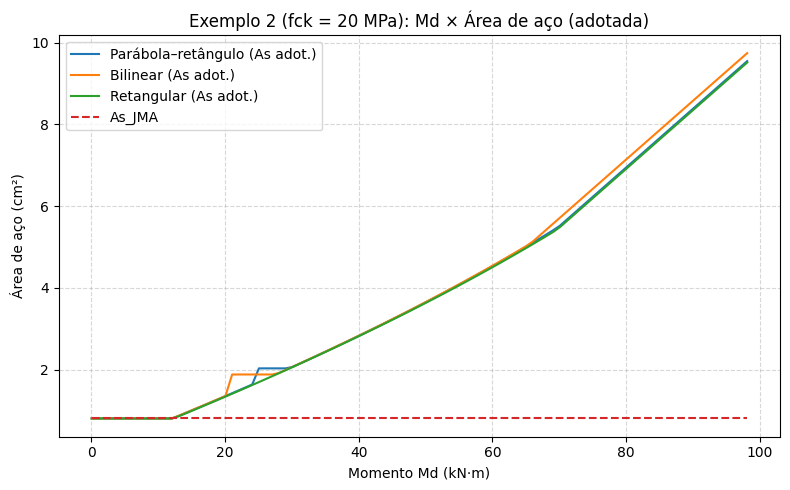

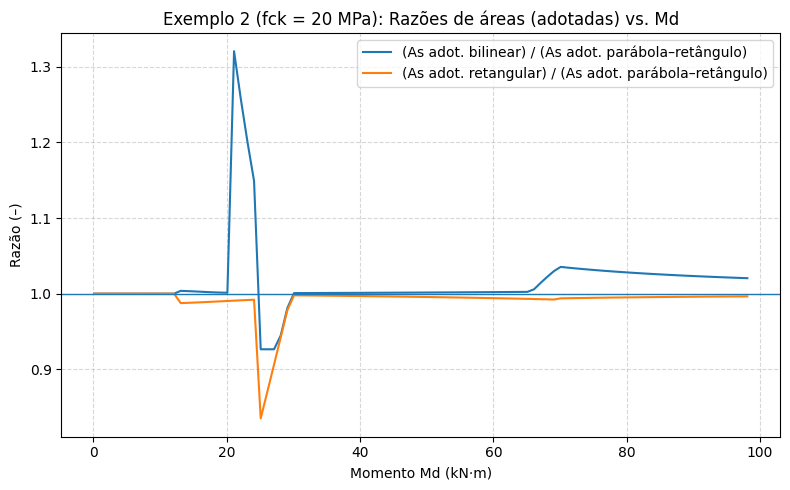

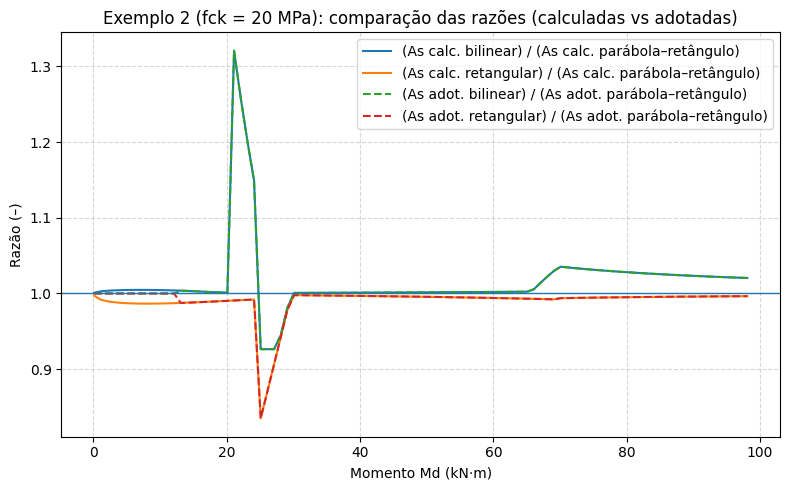

In [32]:
# ===========================================================
# DIMENSIONAMENTO À FLEXÃO NORMAL – 3 DIAGRAMAS DE CONCRETO
# (1) Parábola–retângulo (integração)
# (2) Bilinear (integração)
# (3) Retangular equivalente (alfac, lambda)
#
# Domínios 2/3/4 conforme suas premissas:
# - Entrada x sempre em x_rel = x/d
# - x_lim = min( x34 = eps_cu/(eps_cu+eps_yd), xmax(fck) )
# - Dom 4: fixa x em x_lim e usa ΔM para armadura adicional (As' no topo)
#
# Critério de armadura adotada:
# As_adotada = max( As_calc_total , As_JMA )
# onde As_JMA = rho_JMA * b * d
# (Aqui aplico o mínimo ao "total de aço" para seguir literalmente seu critério.)
# ===========================================================

# -----------------------------
# Geometria (m)
# -----------------------------
b = 0.15
h = 0.40
d = 0.36
d_linha = 0.04  # d' (m)

# -----------------------------
# Aço (CA-50)
# -----------------------------
fyk = 500e6
gam_s = 1.15
fyd = fyk / gam_s
Es = 200e9
eps_yd = fyd / Es

# -----------------------------
# Concreto (segurança)
# -----------------------------
gam_c = 1.40
alpha_c = 0.85

# -----------------------------
# Premissas domínios
# -----------------------------
eps_su = 10.0 / 1000.0  # 10‰

# ===========================================================
# (A) PARÂMETROS DO DIAGRAMA PARÁBOLA–RETÂNGULO
# ===========================================================
def parabola_retangulo(fck_MPa):
    if fck_MPa <= 50.0:
        eo, eu, n = 2.0, 3.5, 2.0
    else:
        eo = 2.0 + 0.085 * (fck_MPa - 50.0)**0.53
        eu = 2.6 + 35.0 * ((90.0 - fck_MPa) / 100.0)**4
        n  = 1.4 + 23.4 * ((90.0 - fck_MPa) / 100.0)**4
    return eo/1000.0, eu/1000.0, n

def xmax(fck_MPa):
    return 0.45 if fck_MPa <= 50.0 else 0.35

def x34(fck_MPa):
    _, eu, _ = parabola_retangulo(fck_MPa)
    return eu / (eu + eps_yd)

def xlim(fck_MPa):
    return min(x34(fck_MPa), xmax(fck_MPa))

def dominio_para(fck_MPa, x_rel):
    eo, _, _ = parabola_retangulo(fck_MPa)
    x23 = eo / (eo + eps_su)
    x_lim = xlim(fck_MPa)
    if x_rel <= x23:
        return 2
    elif x_rel <= x_lim:
        return 3
    else:
        return 4

# ===========================================================
# (B) DIAGRAMA RETANGULAR EQUIVALENTE (NBR 6118)
# ===========================================================
def retangular(fck_MPa):
    if fck_MPa <= 50.0:
        alfac = 0.85
        lbd   = 0.80
    else:
        alfac = 0.85 * (1.0 - (fck_MPa - 50.0)/200.0)
        lbd   = 0.80 - (fck_MPa - 50.0)/400.0
    return alfac, lbd

# ===========================================================
# (C) DIAGRAMA BILINEAR (sua definição)
# ===========================================================
def bilinear(fck_MPa):
    if fck_MPa <= 50.0:
        eo, eu = 1.75, 3.5
    else:
        eo = 1.75 + 0.55*(fck_MPa-50.0)/40.0
        eu = 2.6 + 35.0*((90.0-fck_MPa)/100.0)**4
    return eo/1000.0, eu/1000.0

def sig_tilde_bi(ec, fck_MPa):
    eo, eu = bilinear(fck_MPa)
    k = 0.85/eo
    ec = np.asarray(ec, dtype=float)
    ec = np.maximum(ec, 0.0)
    sig = np.where(ec <= eo, k*ec, 0.85)
    # Para dimensionamento, travo em 0.85 após eu (mesma filosofia do seu modelo anterior)
    sig = np.where(ec > eu, 0.85, sig)
    return sig

# ===========================================================
# (D) SIGMA PARA PARÁBOLA–RETÂNGULO (robusta)
# ===========================================================
def sig_tilde_parab(ec, fck_MPa):
    ec = np.asarray(ec, dtype=float)
    ec = np.maximum(ec, 0.0)

    ec2, eu, n = parabola_retangulo(fck_MPa)
    sig = np.zeros_like(ec)

    m_par = ec <= ec2
    if np.any(m_par):
        ee = ec[m_par]
        sig[m_par] = alpha_c * (1.0 - (1.0 - ee/ec2)**n)

    m_pat = ec > ec2
    if np.any(m_pat):
        sig[m_pat] = alpha_c

    sig = np.minimum(sig, alpha_c)
    sig = np.where(ec > eu, alpha_c, sig)  # mantém patamar após eu
    return sig

# ===========================================================
# (E) ARMADURA MÍNIMA JMA
# ===========================================================
def amin_jma(fck_MPa):
    fyd_MPa = 500.0 / 1.15
    if fck_MPa <= 50.0:
        rho = 0.078 * fck_MPa**(2.0/3.0) / fyd_MPa
    else:
        rho = 0.5512 * np.log(1.0 + 0.11 * fck_MPa) / fyd_MPa
    return max(rho, 0.00150)

def As_jma_m2(fck_MPa, b_m, d_m):
    return amin_jma(fck_MPa) * b_m * d_m  # m²

# ===========================================================
# (F) CONCRETO: RESULTANTES E Mrd PARA CADA MODELO
# ===========================================================
def concreto_resultantes(x_rel, fck_MPa, modelo="parabola", n_int=2500):
    fck = fck_MPa * 1e6
    fcd = fck / gam_c

    x_lim = xlim(fck_MPa)
    dom_geom = dominio_para(fck_MPa, x_rel)

    x_rel_eff = x_lim if dom_geom == 4 else x_rel
    x_abs = np.clip(x_rel_eff * d, 1e-9, 0.999999 * d)

    # Retangular equivalente (bloco)
    if modelo.lower() == "retangular":
        alfac, lbd = retangular(fck_MPa)
        sigma_c = alfac * fcd
        a = lbd * x_abs
        Rcd = sigma_c * b * a
        y_bar = 0.5 * a
        Mrd = Rcd * (d - y_bar)
        return x_abs, Rcd, y_bar, Mrd, dom_geom, x_rel_eff, x_lim

    # Integração (parábola ou bilinear)
    y = np.linspace(0.0, x_abs, n_int)

    if dom_geom == 2:
        eps = eps_su * (x_abs - y) / (d - x_abs)
    else:
        _, eu_para, _ = parabola_retangulo(fck_MPa)
        eps = eu_para * (1.0 - y / x_abs)

    if modelo.lower() == "parabola":
        sigma = fcd * sig_tilde_parab(eps, fck_MPa)
    elif modelo.lower() == "bilinear":
        sigma = fcd * sig_tilde_bi(eps, fck_MPa)
    else:
        raise ValueError("modelo deve ser 'parabola', 'bilinear' ou 'retangular'.")

    Rcd = np.trapz(sigma * b, y)
    My  = np.trapz(sigma * b * y, y)
    y_bar = My / Rcd if Rcd > 0.0 else 0.0
    Mrd = np.trapz(sigma * b * (d - y), y)

    return x_abs, Rcd, y_bar, Mrd, dom_geom, x_rel_eff, x_lim

def momento_resistente(x_rel, fck_MPa, modelo="parabola"):
    _, _, _, Mrd, _, _, _ = concreto_resultantes(x_rel, fck_MPa, modelo=modelo)
    return Mrd

# ===========================================================
# (G) RESOLVE x_rel PARA Md + DETECÇÃO DOM 4
# ===========================================================
def resolve_x_rel_por_momento(Md, fck_MPa, modelo="parabola", tol=1e-6, max_iter=80):
    x_lim = xlim(fck_MPa)

    Mrd_lim = momento_resistente(x_lim, fck_MPa, modelo=modelo)
    if Md > Mrd_lim + tol:
        return x_lim, True

    x_low = 1e-5
    x_high = x_lim

    f_low = Md - momento_resistente(x_low, fck_MPa, modelo=modelo)
    if f_low < 0.0:
        return x_low, False

    for _ in range(max_iter):
        x_mid = 0.5 * (x_low + x_high)
        f_mid = Md - momento_resistente(x_mid, fck_MPa, modelo=modelo)

        if abs(f_mid) < tol:
            return x_mid, False

        if f_mid > 0.0:
            x_low = x_mid
        else:
            x_high = x_mid

    return 0.5 * (x_low + x_high), False

# ===========================================================
# (H) ARMADURAS (As_calc_total e As_adotada = max(As_calc_total, As_JMA))
# ===========================================================
def armaduras_por_caso(fck_MPa, Md_kNm, modelo="parabola", n_int=2500):
    Md = Md_kNm * 1e3

    x_rel_sol, force4 = resolve_x_rel_por_momento(Md, fck_MPa, modelo=modelo)
    x_abs, Rcd, y_bar, Mrd, dom_geom, x_rel_eff, x_lim = concreto_resultantes(
        x_rel_sol, fck_MPa, modelo=modelo, n_int=n_int
    )

    dom_dim = 4 if force4 else dom_geom

    if dom_dim in (2, 3):
        As_inf = Rcd / fyd
        As_sup = 0.0
        DeltaM = 0.0
    else:
        As1 = Rcd / fyd
        DeltaM = max(Md - Mrd, 0.0)

        z_aco = d - d_linha
        if z_aco <= 0.0:
            raise ValueError("Geometria inválida: d' deve ser menor que d.")

        As_add = DeltaM / (fyd * z_aco)
        As_inf = As1 + As_add
        As_sup = As_add

    As_calc_total = As_inf + As_sup
    AsJMA = As_jma_m2(fck_MPa, b, d)
    As_adotada = np.maximum(As_calc_total, AsJMA)

    return {
        "modelo": modelo,
        "fck_MPa": fck_MPa,
        "Md_kNm": Md_kNm,
        "dom": dom_dim,
        "x_rel": x_rel_sol,
        "x_cm": x_rel_eff * d * 100.0,
        "Mrd_kNm": Mrd / 1e3,
        "DeltaM_kNm": DeltaM / 1e3,
        "As_calc_cm2": As_calc_total * 1e4,
        "As_jma_cm2": AsJMA * 1e4,
        "As_adot_cm2": As_adotada * 1e4
    }

# ===========================================================
# (I) GRÁFICOS – EXEMPLO 2 (fck=20 MPa, Md 0..98 kN·m)
# ===========================================================
fck_MPa = 20.0
Md_vals = np.arange(.1, 99.0, 1.0)

def curva_As(modelo):
    As_calc = []
    As_adot = []
    As_jma  = []
    for Md in Md_vals:
        r = armaduras_por_caso(fck_MPa, Md, modelo=modelo)
        As_calc.append(r["As_calc_cm2"])
        As_adot.append(r["As_adot_cm2"])
        As_jma.append(r["As_jma_cm2"])
    return np.array(As_calc), np.array(As_adot), np.array(As_jma)

As_calc_para, As_adot_para, Asjma = curva_As("parabola")
As_calc_bi,   As_adot_bi,   _     = curva_As("bilinear")
As_calc_ret,  As_adot_ret,  _     = curva_As("retangular")

# Gráfico 1: Md × As_adotada (3 curvas)
plt.figure(figsize=(8, 5))
plt.plot(Md_vals, As_adot_para, label="Parábola–retângulo (As adot.)")
plt.plot(Md_vals, As_adot_bi,   label="Bilinear (As adot.)")
plt.plot(Md_vals, As_adot_ret,  label="Retangular (As adot.)")
plt.plot(Md_vals, Asjma,        label="As_JMA", linestyle="--")
plt.xlabel("Momento Md (kN·m)")
plt.ylabel("Área de aço (cm²)")
plt.title("Exemplo 1 (fck = 20 MPa): Md × Área de aço (adotada)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico 2: Md × Razões usando As_adotada
#ratio_bi_adot  = np.full_like(Md_vals, np.nan, dtype=float)
#ratio_ret_adot = np.full_like(Md_vals, np.nan, dtype=float)
#mask = As_adot_para > 0.0
#ratio_bi_adot[mask]  = As_adot_bi[mask]  / As_adot_para[mask]
#ratio_ret_adot[mask] = As_adot_ret[mask] / As_adot_para[mask]

#plt.figure(figsize=(8, 5))
#plt.plot(Md_vals, ratio_bi_adot,  label="(As adot. bilinear) / (As adot. parábola–retângulo)")
#plt.plot(Md_vals, ratio_ret_adot, label="(As adot. retangular) / (As adot. parábola–retângulo)")
#plt.axhline(1.0, linewidth=1)
#plt.xlabel("Momento Md (kN·m)")
#plt.ylabel("Razão (–)")
#plt.title("Exemplo 2 (fck = 20 MPa): Razões de áreas (adotadas) vs. Md")
#plt.grid(True, linestyle="--", alpha=0.5)
#plt.legend()
#plt.tight_layout()
#plt.show()

# Gráfico 3: Comparação das razões "calculadas" vs "adotadas"
ratio_bi_calc  = np.full_like(Md_vals, np.nan, dtype=float)
ratio_ret_calc = np.full_like(Md_vals, np.nan, dtype=float)
mask2 = As_calc_para > 0.0
ratio_bi_calc[mask2]  = As_calc_bi[mask2]  / As_calc_para[mask2]
ratio_ret_calc[mask2] = As_calc_ret[mask2] / As_calc_para[mask2]

plt.figure(figsize=(8, 5))
plt.plot(Md_vals, ratio_bi_calc,  label="(As calc. bilinear) / (As calc. parábola–retângulo)")
plt.plot(Md_vals, ratio_ret_calc, label="(As calc. retangular) / (As calc. parábola–retângulo)")
plt.plot(Md_vals, ratio_bi_adot,  label="(As adot. bilinear) / (As adot. parábola–retângulo)", linestyle="--")
plt.plot(Md_vals, ratio_ret_adot, label="(As adot. retangular) / (As adot. parábola–retângulo)", linestyle="--")
plt.axhline(1.0, linewidth=1)
plt.xlabel("Momento Md (kN·m)")
plt.ylabel("Razão (–)")
plt.title("Exemplo 2 (fck = 20 MPa): comparação das razões (calculadas vs adotadas)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## Referências Bibliográficas

ASSOCIAÇÃO BRASILEIRA DE NORMAS TÉCNICAS. **NBR 6118: Projeto de estruturas de concreto — Procedimento**. Rio de Janeiro: ABNT, 2003.

ASSOCIAÇÃO BRASILEIRA DE NORMAS TÉCNICAS. **NBR 6118: Projeto de estruturas de concreto — Procedimento**. Rio de Janeiro: ABNT, 2014.

ASSOCIAÇÃO BRASILEIRA DE NORMAS TÉCNICAS. **NBR 6118: Projeto de estruturas de concreto — Procedimento**. Rio de Janeiro: ABNT, 2023.

ARAÚJO, José Milton de. **Curso de concreto armado: tópicos avançados**. Rio Grande, RS: Editora Dunas, 2023.

CARVALHO, Roberto Chust; FIGUEIREDO FILHO, Jasson Rodrigues de. **Cálculo e detalhamento de estruturas usuais de concreto armado**. 4. ed. São Carlos : EdUFSCar, 2019.

KIMURA, A. E.; PARSEKIAN, G. A.; ALMEIDA, L. C.; SANTOS, S. H. C.; BITTENCOURT, T. N. **Estruturas de concreto armado**. Volume 1. São Paulo: Instituto Brasileiro do Concreto (IBRACON), 2022.
